In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import expon
from scipy.optimize import minimize
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
print(10)

10


In [138]:
def Z(mu, sigma):
    return(norm.cdf(mu/sigma))

def g(x, mu, sigma):
    return((x >= 0)*norm.pdf(x, mu, sigma)/(Z(mu, sigma)))

def params(i, mu, Q, X):
    mu_x = mu[i]-np.sum([Q[i,j]*(X[j]-mu[j]) for j in range(len(mu)) if j != i])/Q[i,i]
    sigma_squared_x = 1/Q[i,i]
    return(mu_x, sigma_squared_x)

def params_d(a, i, mu, Sigma, Q):
    d = len(mu)
    mu_1 = np.delete(mu, i)
    mu_2 = mu[i]
    Sigma_11 = np.delete(np.delete(Sigma, i, axis = 0),i, axis = 1).reshape(d-1,d-1)
    Sigma_22 = 1/Sigma[i,i]
    Sigma_21 = np.delete(Sigma[i,:], i)
    mu_1_a = mu_1+Sigma_21*Sigma_22*(a-mu_2)
    Sigma_11_a = Sigma_11 - Sigma_22*Sigma_21.reshape((-1,1)) @ Sigma_21.reshape((1,-1))
    return(mu_1_a, Sigma_11_a)

def dense(y, i, mu, Sigma, Q, fun, Z_cst):
    d = len(mu)
    X_i = np.ones(d-1)
    X = np.ones(d)
    X[i] = y
    mu_c, Sigma_c = params_d(y, i, mu, Sigma, Q)
    if(d == 3):
        Z_cst_cx = (1-norm.cdf(0,loc=mu_c[0],scale=np.sqrt(Sigma_c[0,0]))
              -norm.cdf(0,loc=mu_c[1],scale=np.sqrt(Sigma_c[1,1]))
              +multivariate_normal.cdf(np.zeros(2),mean=mu_c,cov=Sigma_c))
    else:
        Z_cst_cx = fun(mu_c, Sigma_c)
    d1 = (0 <= X).all()*(multivariate_normal.pdf(X, mean = mu, cov = Sigma))/(Z_cst)
    d2 = (0 <= X_i).all()*(multivariate_normal.pdf(X_i, mean = mu_c, cov = Sigma_c))/(Z_cst_cx)
    return(d1/d2)

def dense_1(y, i, mu, Sigma, Q):
    Z_cst = (1-norm.cdf(0,loc=mu[0],scale=np.sqrt(Sigma[0,0]))
              -norm.cdf(0,loc=mu[1],scale=np.sqrt(Sigma[1,1]))
              +multivariate_normal.cdf(np.zeros(2),mean=mu,cov=Sigma))
    X = np.ones(len(mu))
    j = 0 if i == 1 else 1
    X[i] = y
    p = params(j, mu, Q, X)
    d1 = (0. <= X).all()*(multivariate_normal.pdf(X, mean = mu, cov = Sigma))/(Z_cst)
    d2 = g(1, p[0], np.sqrt(p[1]))
    return(d1/d2)

def plot_Gibbs_2D(X, mu, Sigma):
    d = len(mu)
    Q = np.linalg.inv(Sigma)
    fig, axs = plt.subplots(d, figsize = (10,15))
    for t in range(d):
        x = np.linspace(0, 10, 100)
        y = np.array([dense_1(xx, t, mu, Sigma, Q) for xx in x])
        axs[t].hist(X[:,t], density = True, bins = 40, label = "Histogramme des simulations")
        axs[t].plot(x, y, label = "Densité théorique")
    fig.suptitle('Densités théoriques et pratiques', y = 0.9)
    
def plot_Gibbs(X, mu, Sigma):
    d = len(mu)
    Q = np.linalg.inv(Sigma)
    fig, axs = plt.subplots(d, figsize = (10,15))
    Z_cst = fun(mu, Sigma, 10000)
    for t in range(d):
        x = np.linspace(0, 10, 100)
        y = np.array([dense(xx, t, mu, Sigma, Q, fun, Z_cst) for xx in x])
        axs[t].hist(X[:,t], density = True, bins = 40, label = "Histogramme des simulations")
        axs[t].plot(x, y, label = "Densité théorique")
    fig.suptitle('Densités théoriques et pratiques', y = 0.9)

In [ ]:
def M1(mu, sigma):
    return(1/Z(mu, sigma))

def Lambda_Star(mu, sigma):
    Delta = mu*mu+4*sigma*sigma
    return((-mu+np.sqrt(Delta))/(2*sigma*sigma))

def M2(mu, sigma):
    L_Star = Lambda_Star(mu, sigma)
    return((np.exp(mu*L_Star+sigma*sigma*L_Star*L_Star/2))/(L_Star*Z(mu, sigma)*np.sqrt(2*np.pi)*sigma))

def AR_Norm_Simple(mu, sigma):
    X = -1
    M_1 = M1(mu, sigma)
    M_2 = M2(mu, sigma)
    if(M_2 >= M_1):
        while(X == -1):
            Y = mu+sigma*norm.rvs()
            if(Y > 0):
                X = Y
    else:
        while(X == -1):
            L_Star = Lambda_Star(mu, sigma)
            Y = expon.rvs(scale = 1/L_Star)
            U = uniform.rvs()
            if(g(Y, mu, sigma)/(M_2*expon.pdf(Y, scale = 1/L_Star)) >= U):
                X = Y
    return(X) 

In [4]:
def SOV(mu, Sigma, n = 1000):
    k = len(mu)
    X = np.zeros((n, k))
    L = np.linalg.cholesky(Sigma)
    U = uniform.rvs(size = n*k)
    for n_ in range(n):
        for k_ in range(k):
            l_ = (-mu[k_]-np.sum(X[n_,:k_]*L[k_,:k_]))/L[k_,k_]
            X[n_, k_] = norm.ppf(norm.cdf(l_)+U[n_*k+k_]*(1-norm.cdf(l_)))
    return(X)

def fun(mu, Sigma, n = 1000):
    k = len(mu)
    X = np.zeros((n, k))
    Val = np.ones(n)
    L = np.linalg.cholesky(Sigma)
    U = uniform.rvs(size = n*k)
    for n_ in range(n):
        for k_ in range(k):
            l_ = (-mu[k_]-np.sum(X[n_,:k_]*L[k_,:k_]))/L[k_,k_]
            X[n_, k_] = norm.ppf(norm.cdf(l_)+U[n_*k+k_]*(1-norm.cdf(l_)))
            Val[n_] *= 1-norm.cdf(l_)
    return(np.mean(Val))

In [5]:
def in_int(x, l, u, L):
    return(np.prod((l < np.dot(L, x))*(np.dot(L, x) < u)))

In [6]:
def Cons_l(P, l, u, L):
    taille = int(len(P)/2)
    x = P[:taille]
    return(np.concatenate((np.dot(L, x)-l,u-np.dot(L, x))))

def Cons_u(P, u, L):
    taille = int(len(P)/2)
    x = P[:taille]
    return(u-np.dot(L, x))

In [81]:
def l_tilde(x, mu, L):
    return([(-mu[i]-np.sum(x[:i]*L[i, :i]))/L[i, i] for i in range(len(x))])

def phi(x):
    return(np.prod(norm.pdf(x)))

In [88]:
def psi(P, m, L):
    taille = int(len(P)/2)
    x = P[:taille]
    mu = P[taille:]
    l_app = l_tilde(x, m, L)
    return((-(x @ mu.T)+(mu @ mu.T)/2+np.sum([np.log(1-norm.cdf(l_app[k]-mu[k])) for k in range(len(x))])))

In [83]:
def dpsi(P, m, L):
    taille = int(len(P)/2)
    x = P[:taille]
    mu = P[taille:]
    l_app = l_tilde(x, m, L)
    Psi = np.array([(norm.pdf(l_app[j], loc = mu[j]))/\
                    (1-norm.cdf(l_app[j]-mu[j])) for j in range(len(x))])
    D = np.diag(np.diag(L))
    L_tilde = np.dot(np.linalg.inv(D), L)
    dpsi_x = -mu+np.dot((L_tilde.T-np.diag(np.ones(len(x)))), Psi)
    dpsi_mu = mu-x+Psi
    return(np.concatenate((dpsi_x, dpsi_mu)))

In [84]:
def ddpsi(P, m, L):
    taille = int(len(P)/2)
    x = P[:taille]
    mu = P[taille:]
    t = len(x)
    H = np.zeros((2*t, 2*t))
    l_app = l_tilde(x, m, L)
    Psi = np.array([(norm.pdf(l_app[j], loc = mu[j]))/\
                    (1-norm.cdf(l_app[j]-mu[j])) for j in range(len(x))])
    Psi_prime = np.array([(l_app[j]-mu[j])*Psi[j]-Psi[j]**2 for j in range(len(x))])
    D = np.diag(np.diag(L))
    L_tilde = np.dot(np.linalg.inv(D), L)
    H[:t, :t] = np.dot(np.dot((L_tilde-np.diag(np.ones(t))).T, np.diag(Psi_prime)), (L_tilde-np.diag(np.ones(t))))
    H[t:, :t] = (np.dot((L_tilde-np.diag(np.ones(t))), np.diag(Psi_prime))-np.diag(np.ones(t)))
    H[:t, t:] = H[t:, :t].T
    H[t:, t:] = np.diag(np.ones(t)+Psi_prime)
    return(H)

In [109]:
mu = np.array([0.,3.,2.])
Sigma = np.array([[1.,0.5,0.5],
                  [0.5,1.,0.5],
                  [0.5,0.5,2.]])
L = np.linalg.cholesky(Sigma)
P0 = np.array([0.7,0.7,0.7,0.75,0.75,0.3])

In [111]:
np.dot(L, P0[:3])

array([0.7       , 0.95621778, 1.45576871])

In [112]:
from scipy.optimize import fsolve

res = fsolve(dpsi, P0, fprime = ddpsi, args = (mu, L))

In [113]:
np.exp(psi(res, mu, L))

0.4843304552649469

In [93]:
np.dot(L, res[:2])

array([0.91128553, 0.8850411 ])

In [97]:
(1-norm.cdf(0,loc=mu[0],scale=np.sqrt(Sigma[0,0]))
              -norm.cdf(0,loc=mu[1],scale=np.sqrt(Sigma[1,1]))
              +multivariate_normal.cdf(np.zeros(2),mean=mu,cov=Sigma))

0.4999590551690839

In [118]:
def g2(X, mu = mu, L = L, m = res[3:]):
    l_app = l_tilde(X, mu, L)
    g_d = 1
    for k in range(len(X)):
        g_d *= norm.pdf(X[k], loc = m[k])/(1-norm.cdf(l_app[k]-mu[k]))
    return(g_d)

In [102]:
def G(mu, L, m):
    k = len(mu)
    X = np.zeros(k)
    U = uniform.rvs(size = k)
    for k_ in range(k):
        l_app = (-mu[k_]-np.sum(X[:k_]*L[k_,:k_]))/L[k_,k_]
        X[k_] = m[k_]+norm.ppf(norm.cdf(l_app-m[k_])+U[k_]*(1-norm.cdf(l_app-m[k_])))
    return(X)

In [100]:
def AR(c, g, G, mu, L, m):
    U = uniform.rvs()
    X = G(mu, L, m)
    while(c*U > phi(X)/g(X)):
        U = uniform.rvs()
        X = G(mu, L, m)
    return(X)

In [119]:
n = 10000
Test = np.array([mu+np.dot(L, AR(np.exp(psi(res, mu, L)), g2, G, mu, L, res[3:])) for _n in range(n)])

In [124]:
Test

array([[2.81902654, 5.39167543, 3.44916564],
       [0.72389023, 3.71690548, 2.80969292],
       [0.44700585, 3.28089779, 1.41144292],
       ...,
       [0.17971831, 4.49313601, 4.08901909],
       [0.07216987, 3.59295043, 2.70447001],
       [1.94230892, 3.90115918, 1.49250655]])

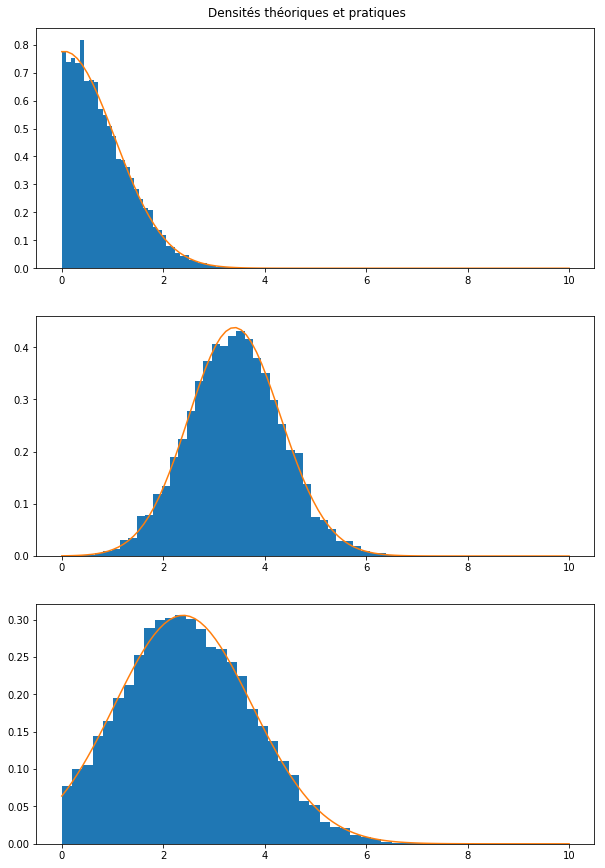

In [140]:
plot_Gibbs(Test, mu, Sigma)